In [1]:
"""
Table 1
"""

'\nTable 1\n'

In [8]:
#Import packages to facilitate this research
import os, random
SEED = 2                                
os.environ["PYTHONHASHSEED"]  = str(SEED) 
os.environ["TF_DETERMINISTIC_OPS"] = "1" 
random.seed(SEED)  
import numpy as np 
np.random.seed(SEED)    
import tensorflow as tf #(https://www.tensorflow.org/install)
tf.keras.utils.set_random_seed(SEED)      
tf.config.experimental.enable_op_determinism() 
from tensorflow.keras import (layers,Model) 
from tensorflow.keras.layers import (Layer, Input, Dense, Concatenate, Activation, TimeDistributed,
Flatten, Lambda, GlobalAveragePooling1D, LeakyReLU) 
from tensorflow.keras.utils import to_categorical 
from concretedropout.tensorflow import (ConcreteDenseDropout, ConcreteSpatialDropout1D, # https://github.com/aurelio-amerio/ConcreteDropout
get_weight_regularizer, get_dropout_regularizer) 
from sktime.classification.deep_learning import InceptionTimeClassifier #https://www.sktime.net/en/stable/get_started.html
from sktime.classification.ensemble import BaggingClassifier
from aeon.classification.convolution_based import MultiRocketHydraClassifier #https://www.aeon-toolkit.org/en/stable/installation.html
from aeon.classification.early_classification import TEASER
from aeon.classification.hybrid import HIVECOTEV2
from sklearn.metrics import (accuracy_score, mean_absolute_error, mean_squared_error,  # https://scikit-learn.org/stable/install.html
classification_report)
from sklearn.model_selection import train_test_split
from math import comb
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from statsmodels.stats.contingency_tables import mcnemar
from tensorflow.keras.layers import Reshape

/opt/anaconda3/lib/python3.12/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


In [9]:
G = 9.81         
DT = 0.025        
M = 10           
K = 60           
N = 10_000       
SEED = 42
rng = np.random.default_rng(SEED)
ZONE_X = (12.0, 14.0)   
WAIST_H = 1.00           
EPSILON = 0.025           
ALPHA = 0.20           
def simulate_throw(dt=DT, m=M, k=60, g=G, rng=rng):
    tot = m + k
    v0 = rng.uniform(10, 15)
    theta = np.deg2rad(rng.uniform(20, 40))
    vx, vy = v0 * np.cos(theta), v0 * np.sin(theta)
    x, y = 0.0, rng.uniform(1.0, 1.1)
    base_wind = rng.normal(0.0, 1.0)  
    wind_change = rng.normal(0.0, 6.0)  
    traj = np.empty((tot, 2), np.float32)
    for t in range(tot):
        traj[t, 0] = x + rng.normal(0, 0.15)  
        traj[t, 1] = y + rng.normal(0, 0.15)
        if y <= 0:
            traj[t:, 1] = 0.0
            break
        if t*dt > 0.25:
            wind = base_wind + wind_change
            drag = rng.uniform(0.08, 0.12)
        else:
            wind = base_wind
            drag = rng.uniform(0.03, 0.05)
        ax = wind - drag * vx
        ay = -g - drag * vy
        vx += ax * dt
        vy += ay * dt
        x += vx * dt
        y += vy * dt
    return traj[:m], traj[m:m+k]
obs, fut = zip(*(simulate_throw() for _ in range(N)))
X_obs = np.stack(obs,  axis=0)          
X_future = np.stack(fut,  axis=0)          
x_fut = X_future[..., 0]
y_fut = X_future[..., 1]
in_zone = (x_fut >= ZONE_X[0]) & (x_fut <= ZONE_X[1])
h_zone = np.where(in_zone, y_fut, -1.0).max(axis=1)      
y_class = (h_zone >= WAIST_H).astype(int)           
border = np.abs(h_zone - WAIST_H) < EPSILON        
sample_weight = np.ones_like(h_zone, dtype=np.float32)
sample_weight[border] = ALPHA
print(f"Total trajectories      : {N:,}")
print(f"Grey-band (down-weighted): {border.sum():,}")
Xo_tr, Xo_te, Xf_tr, Xf_te, yc_tr, yc_te, sw_tr, sw_te = train_test_split(
        X_obs, X_future, y_class, sample_weight,test_size=0.20, random_state=SEED, stratify=y_class)
print("Train shapes  Xo_tr:", Xo_tr.shape," positives:", yc_tr.sum(), "/", len(yc_tr))
print(" Test shapes  Xo_te:", Xo_te.shape," positives:", yc_te.sum(), "/", len(yc_te))


Total trajectories      : 10,000
Grey-band (down-weighted): 61
Train shapes  Xo_tr: (8000, 10, 2)  positives: 3899 / 8000
 Test shapes  Xo_te: (2000, 10, 2)  positives: 975 / 2000


In [10]:
X_observed_train = Xo_tr 
X_observed_test = Xo_te
X_forecast_train = Xf_tr 
X_forecast_test = Xf_te
y_train = to_categorical(yc_tr,num_classes = 3)
y_test = to_categorical(yc_te,num_classes = 3)
print(X_observed_train.shape)
print(X_observed_test.shape)
print(X_forecast_train.shape)
print(X_forecast_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 10, 2)
(2000, 10, 2)
(8000, 60, 2)
(2000, 60, 2)
(8000, 3)
(2000, 3)


In [11]:
Ns = X_observed_train.shape[0]
time_steps = X_observed_train.shape[1]
n_forecast = X_forecast_train.shape[1]
n_classes = y_train.shape[1]
wr = get_weight_regularizer(Ns, l=1e-2, tau=0.5) 
dr = get_dropout_regularizer(Ns, tau=0.5, cross_entropy_loss=True) 

In [12]:
n_features = X_observed_train.shape[2]
def create_custom_filters(filter_length, input_channels=n_features):
    """
    Creates hand-crafted filters duplicated across input channels.
    """
    # Create the 3 base filters for univariate
    filter_1 = np.array([(-1) ** (i + 1) for i in range(filter_length)], dtype=np.float32)
    filter_2 = np.array([(-1) ** i for i in range(filter_length)], dtype=np.float32)
    filter_3 = np.zeros(filter_length, dtype=np.float32)

    for n in range(0, int(((filter_length - 3) / 3) + 1)):
        filter_3[n] = (-3 / filter_length) * comb(int((filter_length - 3) / 3), n)
    for n in range(int(filter_length / 3), int((2 * (filter_length - 3) / 3) + 2)):
        filter_3[n] = (6 / filter_length) * comb(int((filter_length - 3) / 3), int(n - (filter_length / 3)))
    for n in range(int((2 * (filter_length - 3) / 3) + 2), filter_length):
        filter_3[n] = (-3 / filter_length) * comb(int((filter_length - 3) / 3), int(n - (2 * (filter_length - 3) / 3) - 2))

    
    base_filters = np.stack([filter_1, filter_2, filter_3], axis=-1)

    
    base_filters = np.repeat(base_filters[:, np.newaxis, :], input_channels, axis=1)  

    return base_filters.astype(np.float32)

class WelfordMeanVarianceLayer(Layer): #Defining the Welford Mean-variance layer (section 4.2) as a subclass of Layer in Keras 
    def __init__(self, total_series,n_features, n_forecast=4, **kwargs): #constructor of the class, where it takes in the number of time series we want to have mean and variance estimates for and the number of forecasts for each 
        super(WelfordMeanVarianceLayer, self).__init__(**kwargs) #calls the Keras layer class
        self.total_series = total_series #number of series the layer will track 
        self.n_forecast = n_forecast #number of forecast steps ahead 
        self.stats = self.add_weight( #creates a non-trainable tensor to store the means and variances which is initialized with zeros
            shape=(self.total_series, self.n_forecast,n_features, 2),
            initializer="zeros",
            trainable=False,
            name="stats"
        ) 
        self.count = self.add_weight( #creates a non-trainable tensor to count how many samples for the mean and variance we have for the forecasts of a given time series, which are obtained through successive forward passes
            shape=(self.total_series,),
            initializer="zeros",
            trainable=False,
            name="count"
        )
    def reset_statistics(self): #A method to clear the existing estimates of the mean and variance of the forecasts and set them to zero, which you might want to do during testing
        self.stats.assign(tf.zeros_like(self.stats))
        self.count.assign(tf.zeros_like(self.count))
    def call(self, inputs, **kwargs): #main method used when calling the Welford layer in a given forward pass
        forecast_values, series_ids = inputs  #unpacks the inputs into the Welford layer, the forecast values in the current forward pass and the ids of the current time series being processed 
        batch_size = tf.shape(forecast_values)[0] #derives the current batch size from the shape of the forecast values tensor
        def loop_body(i, current_stats, current_count): #defines the body of a while loop to be used in the proceeding lines. Processes the ith time series in the batch by applying Welford's algorithm 
            idx = series_ids[i] #determines the id of the current time series being processed        
            val = forecast_values[i] #the values to be used to update the means and variances of the forecasts
            current_count = tf.tensor_scatter_nd_add(current_count, [[idx]], [1.0]) #increments the count of the number of times we have updated the mean and variance of the given time series 
            old_mean = current_stats[idx, :, :, 0]  #extracts the old forecast means 
            old_var  = current_stats[idx, :, :, 1] #extracts the old forecast variance 
            n = current_count[idx] #number of times we have updated the mean and variance of the forecasts for a given time series 
            delta = val - old_mean #the difference between the new forecast value and the old mean 
            new_mean = old_mean + (delta /n) #formula used in Welford's algorithm to update the mean 
            delta2 = val - new_mean #difference between the new forecast value and the new mean 
            new_var = ((1-(1/n))*old_var) + ((delta*delta2)/n) #update the value of the sample variance using the population variance formula      
            updated_stats = tf.stack([new_mean, new_var], axis=-1) #combines the new values of the sample mean and variance 
            current_stats = tf.tensor_scatter_nd_update(current_stats, [[idx]], [updated_stats]) #overwrites the old values of the mean and variance for a given time series(idx) with the new values of the mean and variance 
            return i+1, current_stats, current_count #set i to i+1 to go to the next time series in the batch, and return the current values of the sample mean and variance, and the number of times the time series have been processed
        i0 = tf.constant(0) #starting index of the loop 
        stats0 = self.stats #the initial stats for the start of the while loop 
        count0 = self.count #the initial counts that each time series has been processed for the start of the while loop 
        _, updated_stats, updated_count = tf.while_loop( #the while loop which outputs the index, the updated stats, and the updated counts 
            cond=lambda i, *_: i < batch_size, #determines if the while loop should continue or not, where the loop stops if i exceeds the batch size as there are no more time series to process in the current batch 
            body=loop_body, #using the function defined earlier which is used in each iteration of the while loop 
            loop_vars=[i0, stats0, count0] #initial values of the variables in the while loop 
        )
        self.stats.assign(updated_stats) #permanently updates the stats variable of the layer which will be used in future calls of the layer 
        self.count.assign(updated_count) #permanently updates the count variable for the layer which will be used in future calls of the layer 
        out_stats_for_batch = tf.gather(self.stats, series_ids) #takes the means and variances for the forecasted time points for the time series in the current batch so they can be passed to the proceeding layer 
        return out_stats_for_batch #returns the means and variances for the forecasted time series in the current batch so they can be passed into the next layer of the network in the current forward pass 
class BoltzmannConv1D(Layer): #Defining the Boltzmann convolutional layer (section 4.1) as a subclass of Layer in Keras 
    def __init__(self, out_channels, kernel_sizes, dilation_rate=1, padding="causal", temperature=1, **kwargs):#contructor of the class which takes in several hyperparameters including the type of padding, dilation rate, and temperature of the Boltzmann distribution
        super(BoltzmannConv1D, self).__init__(**kwargs) #Calls the Keras layer class 
        self.out_channels = out_channels #number of output channels 
        self.kernel_sizes = kernel_sizes #the set of kernel filter lengths 
        self.dilation_rate = dilation_rate #dilation rate of the layer 
        self.padding = padding #type of padding for the layer 
        self.temperature = temperature #value of the temperature for the Boltzmann distribution 
        self.convs = [  #creates a list consisting of sub-convolutional layers with the parameters defined above. The layer is wrapped in a Spatial Concrete Dropout layer 
            ConcreteSpatialDropout1D(
                tf.keras.layers.Conv1D(
                    out_channels, ks,
                    dilation_rate=dilation_rate,
                    padding=padding
                ),
                is_mc_dropout=True,
                weight_regularizer=wr,
                dropout_regularizer=dr
            )
            for ks in kernel_sizes #iterates over the filter lengths in the kernel_sizes list creating associated convolutional layers
        ]
    def build(self, input_shape): #create the weights used in the layers 
        self.probs = self.add_weight(   #logits used in the Boltzmann convolution distribution  which are learnable 
            shape=(len(self.kernel_sizes),),
            initializer="uniform",
            trainable=True,
            name="kernel_probs"
        )
        super(BoltzmannConv1D, self).build(input_shape) #finalizes the build methods by inheriting the build from the overall Keras layer class 
    def call(self, x, training=False): #main method used when calling the Boltzmann layer for a given forward pass 
        kernel_probabilities = tf.nn.softmax(self.probs / self.temperature) #defines the probability discussed in section 4.1 
        conv_outputs = [ #creates the list of the weighted convolution outputs 
            conv(x) * kernel_prob
            for conv, kernel_prob in zip(self.convs, tf.unstack(kernel_probabilities)) #turns the kernel probabilities into a list which are then paired with their associated convolutional layer, with them being multiplied together 
        ]
        out = tf.add_n(conv_outputs) #sums up the weighted convolutional outputs in the list 
        return out #returns the summed output of the weighted convolutional layers according to (2) in section 4.1 
class PredefinedBoltzmannConv1D(Layer):
    def __init__(self, filters, kernel_sizes, dilation_rate, custom_filters, temperature=1, **kwargs):
        super(PredefinedBoltzmannConv1D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_sizes = kernel_sizes
        self.temperature = temperature
        self.custom_filters = custom_filters #pre-defined filters as described in Section 5
        self.dilation_rate = dilation_rate
        self.convs = []
        for ks in kernel_sizes:
            conv_layer = tf.keras.layers.Conv1D(
                filters=filters,
                kernel_size=ks,
                padding="causal",
                use_bias=False,
                dilation_rate=dilation_rate
            )
            self.convs.append(conv_layer)
    def build(self, input_shape):
        for i, (conv_layer, ks) in enumerate(zip(self.convs, self.kernel_sizes)):
            conv_layer.build(input_shape)
            filter_weights = self.custom_filters[ks]
            conv_layer.set_weights([filter_weights])
            conv_layer.trainable = False
        self.probs = self.add_weight(
            shape=(len(self.kernel_sizes),),
            initializer="uniform",
            trainable=True,
            name="kernel_probs"
        )
        super(PredefinedBoltzmannConv1D, self).build(input_shape)
    def call(self, x, training=False):
        kernel_probabilities = tf.nn.softmax(self.probs / self.temperature)
        conv_outputs = [
            conv(x) * kernel_prob
            for conv, kernel_prob in zip(self.convs, tf.unstack(kernel_probabilities))
        ]
        out = tf.add_n(conv_outputs)
        return out

In [13]:
kernel_sizes = [3,6,9] #pre-defined filter lengths (section 5)
custom_filters_dict = {ks: create_custom_filters(ks) for ks in kernel_sizes} #pre-defined filter weights as a function of filter length (4)-(6) in section 5
ts_input = Input(shape=(time_steps, n_features), name="ts_input")   #defining the input time series to ForeClassNet       
series_id_input = Input(shape=(), dtype=tf.int32, name="series_id")   #defining the input time series index to ForeClassNet 

#Parallel layer and concatenation layer#
conv_predefined = PredefinedBoltzmannConv1D(filters=3, kernel_sizes=kernel_sizes,dilation_rate=1, custom_filters=custom_filters_dict)
x1 = conv_predefined(ts_input)
x1 = Activation("relu", name="activation_predefined")(x1)
x2 = BoltzmannConv1D(out_channels=128, kernel_sizes=kernel_sizes, dilation_rate=1)(ts_input)
x2 = Activation("relu", name="activation_learnable")(x2)
concatenated = Concatenate(axis=-1)([x1, x2])

#Boltzmann Convolutional layer#
x3 = BoltzmannConv1D(out_channels=64, kernel_sizes=kernel_sizes, dilation_rate=2)(concatenated)
x3 = Activation("relu")(x3)

#Boltzmann convolutional layer#
x4 = BoltzmannConv1D(out_channels=32, kernel_sizes=kernel_sizes, dilation_rate=4)(x3)
x4 = Activation("relu")(x4)

#Time distributed dense layer#
layer_4 = Dense(n_features, use_bias=False)
layer_4 = ConcreteDenseDropout(layer_4, is_mc_dropout=True, weight_regularizer=wr, dropout_regularizer=dr)
x5 = TimeDistributed(layer_4)(x4)  
x5_reshaped = Reshape((time_steps, n_features))(x5)
x5_expanded = Lambda(lambda x: tf.expand_dims(x, axis=-1))(x5_reshaped)
zeros_tensor = Lambda(lambda x: tf.zeros_like(x))(x5_expanded)
x6_final = Concatenate(axis=-1)([x5_expanded, zeros_tensor])

#Fully connected layer#
layer_6 = Dense(32, use_bias=True)  
layer_6 = ConcreteDenseDropout(layer_6, is_mc_dropout=True,weight_regularizer=wr, dropout_regularizer=dr)
x5_flat = Flatten()(x5)    
x8 = layer_6(x5_flat)
x8 = LeakyReLU(negative_slope=0.01)(x8)

#Fully connected layer and forecast output#
layer_7 = Dense(n_forecast*n_features, use_bias=True)
layer_7 = ConcreteDenseDropout(layer_7, is_mc_dropout=True, weight_regularizer=wr, dropout_regularizer=dr,name="output_forecast")
output_forecast = layer_7(x8)
output_forecast = Reshape((n_forecast, n_features))(output_forecast)

#Welford layer and concatenation layer#
num_series = 10000
welford_forecast_layer = WelfordMeanVarianceLayer(total_series=num_series,n_forecast= n_forecast, n_features=n_features , name="Welford")
output_forecast_final = welford_forecast_layer([output_forecast, series_id_input])
concatenated_2 = Concatenate(axis=1)([x6_final, output_forecast_final])
concatenated_2_flat = Reshape(((X_observed_train.shape[1] + X_forecast_train.shape[1]), 4))(concatenated_2)


#Boltzmann convolutional layer and GAP layer#
x_classification = BoltzmannConv1D(out_channels=32, kernel_sizes=kernel_sizes,dilation_rate=8)(concatenated_2_flat)
x_classification = Activation("relu")(x_classification)
x_classification = GlobalAveragePooling1D()(x_classification)


#Fully connected layer and classification output#
final_classification_layer = Dense(n_classes, use_bias=False)
final_classification_layer = ConcreteDenseDropout(final_classification_layer, is_mc_dropout=True, weight_regularizer=wr,
                                                  dropout_regularizer=dr,
                                                  name="classification_output")
output_classification = final_classification_layer(x_classification)
output_classification = Activation("softmax")(output_classification)

#compilation and summary of ForeClassNet#
model = Model(inputs=[ts_input, series_id_input],outputs=[output_forecast, output_classification]
              ,name="time_series_forecasting_classification_model")
model.compile(optimizer="adam",loss=["mse", "categorical_crossentropy"],metrics=["mse", "accuracy"])
model.summary()

Model: "time_series_forecasting_classification_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ts_input            │ (None, 10, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predefined_boltzma… │ (None, 10, 3)     │        111 │ ts_input[0][0]    │
│ (PredefinedBoltzma… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ boltzmann_conv1d_4  │ (None, 10, 128)   │      4,998 │ ts_input[0][0]    │
│ (BoltzmannConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_predefi… │ (None, 10, 3)     │          0 │ predefined_boltz… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_learnab… │ (None, 10, 128)   │          0 │ boltzmann_conv1d… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 10, 131)   │          0 │ activation_prede… │
│ (Concatenate)       │                   │            │ activation_learn… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ boltzmann_conv1d_5  │ (None, 10, 64)    │    151,110 │ concatenate_3[0]… │
│ (BoltzmannConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 10, 64)    │          0 │ boltzmann_conv1d… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ boltzmann_conv1d_6  │ (None, 10, 32)    │     36,966 │ activation_4[0][… │
│ (BoltzmannConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 10, 32)    │          0 │ boltzmann_conv1d… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 10, 2)     │         65 │ activation_5[0][… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 20)        │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concrete_dense_dro… │ (None, 32)        │        673 │ flatten_1[0][0]   │
│ (ConcreteDenseDrop… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32)        │          0 │ concrete_dense_d… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 10, 2)     │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_forecast     │ (None, 120)       │      3,961 │ leaky_re_lu_1[0]… │
│ (ConcreteDenseDrop… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 10, 2, 1)  │          0 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 60, 2)     │          0 │ output_forecast[

 Total params: 2,610,387 (9.96 MB)

 Trainable params: 200,279 (782.34 KB)

 Non-trainable params: 2,410,108 (9.19 MB)

In [14]:
#Train ForeClassNet
batch_size = 64
epochs = 100
tic = time.perf_counter()
series_id_train = np.arange(Ns, dtype=np.int32)
model.fit(x=[X_observed_train, series_id_train],  y=[X_forecast_train, y_train], batch_size=batch_size,
    epochs=epochs,validation_split=0.1,shuffle=True)
toc = time.perf_counter()
print(f"Time taken for fitting: {toc - tic:.2f} seconds")
time_in_mins = round((toc - tic) / 60)
print("Time in minutes:", time_in_mins)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - activation_7_accuracy: 0.5031 - activation_7_loss: 0.9142 - loss: 31.1523 - reshape_4_loss: 30.3195 - reshape_4_mse: 30.3202 - val_activation_7_accuracy: 0.4925 - val_activation_7_loss: 0.7165 - val_loss: 12.5293 - val_reshape_4_loss: 11.8361 - val_reshape_4_mse: 11.8928
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - activation_7_accuracy: 0.5232 - activation_7_loss: 0.8301 - loss: 12.4782 - reshape_4_loss: 11.7294 - reshape_4_mse: 11.7294 - val_activation_7_accuracy: 0.4925 - val_activation_7_loss: 0.7057 - val_loss: 11.6099 - val_reshape_4_loss: 10.9489 - val_reshape_4_mse: 10.9850
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - activation_7_accuracy: 0.5337 - activation_7_loss: 0.7180 - loss: 11.6663 - reshape_4_loss: 11.0288 - reshape_4_mse: 11.0288 - val_activation_7_accuracy: 0.5562 - val_activation_7_loss: 0.6841 - val_loss: 11.0546 - val_reshape_4_loss: 10.4427 - val_reshape_4_mse: 10.4518
Epoch 4/100
113/

In [15]:
def mc_dropout_predict(model, X_test, test_ids, num_samples=100):
    """
    Peforms Monte Carlo dropout, where dropout is applied at inference time. 
    This takes as input the trained ForeClassNet model, the input observed time series, 
    the id's associated with the time series in the test set, and the number of MC samples which
    is the number of forward passes through the trained ForeClassNet model. 
    """
    forecast_predictions = [] #list to store the forecast output from each forward pass through ForeClassNet
    classification_predictions = [] #list to store the classification output from each forward pass through ForeClassNet
    for _ in tqdm(range(num_samples), desc="MC Dropout passes"):
        forecast, classification = model.predict([X_test, test_ids], verbose=0) #performs a forward pass through the network 
        forecast_predictions.append(forecast) #add the forecast array to the list 
        classification_predictions.append(classification) #add the classification array of probabilities to the list
    forecast_predictions = np.array(forecast_predictions)
    classification_predictions = np.array(classification_predictions) 
    mean_forecast = np.mean(forecast_predictions, axis=0) #take the mean with respect to the MC samples of the forecast output
    std_forecast = np.std(forecast_predictions, axis=0) #take the standard deviation with respect to the MC samples of the forecast output
    mean_classification = np.mean(classification_predictions, axis=0) #take the mean with respect to the MC samples of the classification probabilities
    std_classification = np.std(classification_predictions, axis=0) #take the standard deviation with respect to the MC samples of the classification probabilities
    return (mean_forecast, std_forecast), (mean_classification, std_classification)

In [16]:
n_test_series = X_observed_test.shape[0]
test_series_ids = np.arange(n_test_series, dtype=np.int32)
welford_forecast_layer = model.get_layer("Welford") 
welford_forecast_layer.reset_statistics() #reset the statistics in the Welford layer

In [17]:
# Perform MC Dropout 
(mean_forecast, forecast_uncertainty), (mean_classification, classification_uncertainty) = mc_dropout_predict(
    model,X_observed_test,    test_series_ids,    num_samples=100)
predicted_classes = np.argmax(mean_classification, axis=-1) #obtain the predicted classess 
print("Predicted classes:", predicted_classes)
classification_accuracy = accuracy_score(np.argmax(y_test, axis=1), predicted_classes) 
print(classification_accuracy)
classification__report = classification_report(np.argmax(y_test, axis=1),predicted_classes,digits = 3) #assess classification performance
print(classification__report)

MC Dropout passes: 100%|██████████████████████| 100/100 [01:15<00:00,  1.32it/s]

Predicted classes: [0 1 1 ... 1 1 0]
0.7715
              precision    recall  f1-score   support

           0      0.819     0.711     0.761      1025
           1      0.733     0.835     0.781       975

    accuracy                          0.771      2000
   macro avg      0.776     0.773     0.771      2000
weighted avg      0.777     0.771     0.771      2000



In [18]:
mse_model = np.mean((mean_forecast - X_forecast_test)**2)
print("Model forecast MSE:            ", mse_model)

Model forecast MSE:             4.643431


In [19]:
MRhydra = MultiRocketHydraClassifier() #initialize the MR-Hydra classifier 
tic = time.perf_counter()
MRhydra.fit(X_observed_train.transpose(0, 2, 1), np.argmax(y_train,axis = 1))  #train the MR-Hydra classifier on the observed time series
toc = time.perf_counter()
print(f"Time taken for fitting: {toc - tic:.2f} seconds")
predictions = MRhydra.predict(X_observed_test.transpose(0, 2, 1)) #test the trained MR-Hydra classifier on the observed test set 
classification_accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(classification_accuracy)
classification__report = classification_report(np.argmax(y_test, axis=1),predictions,digits = 3)
print(classification__report)

Time taken for fitting: 82.58 seconds
0.6945
              precision    recall  f1-score   support

           0      0.712     0.678     0.695      1025
           1      0.678     0.712     0.694       975

    accuracy                          0.695      2000
   macro avg      0.695     0.695     0.694      2000
weighted avg      0.695     0.695     0.695      2000



In [20]:
early = TEASER(classification_points=[10]) #initalize the teaser classifier, specifying we want to make the classification decision after we have observed 10 time points 
tic = time.perf_counter()
early.fit(X_observed_train.transpose(0,2,1), np.argmax(y_train,axis = 1)) #train the teaser classifier 
toc = time.perf_counter()
print(f"Time taken for fitting: {toc - tic:.2f} seconds")
predictions, decisions = early.predict(X_observed_test.transpose(0,2,1)) #evaluate the trained teaser classifier 
classification_accuracy = accuracy_score(np.argmax(y_test,axis = 1), predictions)
print(f"Classification Test Accuracy: {classification_accuracy}")
classification__report = classification_report(np.argmax(y_test, axis=1),predictions, digits = 3)
print(classification__report)

Time taken for fitting: 16.31 seconds
Classification Test Accuracy: 0.6175
              precision    recall  f1-score   support

           0      0.626     0.628     0.627      1025
           1      0.608     0.606     0.607       975

    accuracy                          0.618      2000
   macro avg      0.617     0.617     0.617      2000
weighted avg      0.617     0.618     0.617      2000



In [21]:
#Occasionally Inception can give an error. If this happens rerun the code block again. 
clf1 = BaggingClassifier(InceptionTimeClassifier(n_epochs=100, batch_size = 64),n_estimators=5,bootstrap=False)  #Initialize the inception time classifier 
tic = time.perf_counter() #time how long it takes for training 
clf1.fit(X_observed_train.transpose(0,2,1), np.argmax(y_train,axis = 1)) #train the inception time classifier 
toc = time.perf_counter()
print(f"Time taken for fitting: {toc - tic:.2f} seconds") #how long the inception time classifier took to train 
clf_predictions_1 = clf1.predict(X_observed_test.transpose(0,2,1)) #evaluating the trained inception time classifier on the observed test set (excludes forecast time points)
classification_accuracy = accuracy_score(np.argmax(y_test, axis = 1),clf_predictions_1 )
print(f"Classification Test Accuracy: {classification_accuracy}")
classification__report = classification_report(np.argmax(y_test, axis=1),clf_predictions_1 ,digits = 3) #evaluate its performance on the test set 
print(classification__report)

Time taken for fitting: 2189.14 seconds
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Classification Test Accuracy: 0.7355
              precision    recall  f1-score   support

           0      0.748     0.730     0.739      1025
           1      0.723     0.742     0.732       975

    accuracy                          0.736      2000
   macro avg      0.736     0.736     0.735      2000
weighted avg      0.736     0.736     0.736      2000



In [22]:
a = b = c = d = 0
for i in range(len(y_test)):
    correct_1 = (clf_predictions_1[i] == np.argmax(y_test[i]))
    correct_2 = (predicted_classes[i] == np.argmax(y_test[i]))
    
    if  correct_1 and  correct_2:
        a += 1
    elif correct_1 and not correct_2:
        b += 1
    elif not correct_1 and correct_2:
        c += 1
    else:
        d += 1

table = [[a, b],
         [c, d]]
print("Contingency table:")
print(np.array(table))
result = mcnemar(table, exact=False, correction=True)
print("statistic:", result.statistic)
print("p-value:  ", result.pvalue)

Contingency table:
[[1364  107]
 [ 179  350]]
statistic: 17.625874125874127
p-value:   2.6890483082397162e-05


In [24]:
hc2 = HIVECOTEV2(time_limit_in_minutes= 180)
y_train_labels = np.argmax(y_train, axis=1)
tic = time.perf_counter()
hc2.fit(X_observed_train.transpose(0, 2, 1),y_train_labels)
toc = time.perf_counter()
print(f"Time taken for fitting: {toc - tic:.2f} seconds")
predictions = hc2.predict(X_observed_test.transpose(0, 2, 1))
classification_accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f"Classification Test Accuracy: {classification_accuracy}")
from sklearn.metrics import classification_report
classification__report = classification_report(np.argmax(y_test, axis=1),predictions,digits = 3)
print(classification__report)

Time taken for fitting: 9647.00 seconds
Classification Test Accuracy: 0.7365
              precision    recall  f1-score   support

           0      0.748     0.733     0.740      1025
           1      0.725     0.741     0.733       975

    accuracy                          0.737      2000
   macro avg      0.736     0.737     0.736      2000
weighted avg      0.737     0.737     0.737      2000



In [25]:
a = b = c = d = 0
for i in range(len(y_test)):
    correct_1 = (predictions[i] == np.argmax(y_test[i]))
    correct_2 = (predicted_classes[i] == np.argmax(y_test[i]))
    
    if  correct_1 and  correct_2:
        a += 1
    elif correct_1 and not correct_2:
        b += 1
    elif not correct_1 and correct_2:
        c += 1
    else:
        d += 1

table = [[a, b],
         [c, d]]
print("Contingency table:")
print(np.array(table))
result = mcnemar(table, exact=False, correction=True)
print("statistic:", result.statistic)
print("p-value:  ", result.pvalue)

Contingency table:
[[1375   98]
 [ 168  359]]
statistic: 17.898496240601503
p-value:   2.330051433444981e-05


In [26]:
Ns = X_observed_train.shape[0]
time_steps = X_observed_train.shape[1]
n_forecast = X_forecast_train.shape[1]
n_classes = y_train.shape[1]
wr = get_weight_regularizer(Ns, l=1e-2, tau=0.5) #Determines the amount of regularization on the weights in the concrete dropout layers of ForeClass net
dr = get_dropout_regularizer(Ns, tau=0.5, cross_entropy_loss=True) #Determines the amount of regularization on the dropout probabilities of ForeClass net

In [27]:
kernel_sizes = [3,6,9] #pre-defined filter lengths (section 5)
custom_filters_dict = {ks: create_custom_filters(ks) for ks in kernel_sizes} #pre-defined filter weights as a function of filter length (4)-(6) in section 5
ts_input = Input(shape=(time_steps, n_features), name="ts_input")   #defining the input time series to ForeClassNet       
series_id_input = Input(shape=(), dtype=tf.int32, name="series_id")   #defining the input time series index to ForeClassNet 

#Parallel layer and concatenation layer#
conv_predefined = PredefinedBoltzmannConv1D(filters=3, kernel_sizes=kernel_sizes,dilation_rate=1, custom_filters=custom_filters_dict)
x1 = conv_predefined(ts_input)
x1 = Activation("relu", name="activation_predefined")(x1)
x2 = BoltzmannConv1D(out_channels=128, kernel_sizes=kernel_sizes, dilation_rate=1)(ts_input)
x2 = Activation("relu", name="activation_learnable")(x2)
concatenated = Concatenate(axis=-1)([x1, x2])

#Boltzmann Convolutional layer#
x3 = BoltzmannConv1D(out_channels=64, kernel_sizes=kernel_sizes, dilation_rate=2)(concatenated)
x3 = Activation("relu")(x3)

#Boltzmann convolutional layer#
x4 = BoltzmannConv1D(out_channels=32, kernel_sizes=kernel_sizes, dilation_rate=4)(x3)
x4 = Activation("relu")(x4)

#Time distributed dense layer#
layer_4 = Dense(n_features, use_bias=False)
layer_4 = ConcreteDenseDropout(layer_4, is_mc_dropout=True, weight_regularizer=wr, dropout_regularizer=dr)
x5 = TimeDistributed(layer_4)(x4)  
x5_reshaped = Reshape((time_steps, n_features))(x5)
x5_expanded = Lambda(lambda x: tf.expand_dims(x, axis=-1))(x5_reshaped)
zeros_tensor = Lambda(lambda x: tf.zeros_like(x))(x5_expanded)
x6_final = Concatenate(axis=-1)([x5_expanded, zeros_tensor])

#Fully connected layer#
layer_6 = Dense(32, use_bias=True)  
layer_6 = ConcreteDenseDropout(layer_6, is_mc_dropout=True,weight_regularizer=wr, dropout_regularizer=dr)
x5_flat = Flatten()(x5)    
x8 = layer_6(x5_flat)
x8 = LeakyReLU(negative_slope=0.01)(x8)

#Fully connected layer and forecast output#
layer_7 = Dense(n_forecast*n_features, use_bias=True)
layer_7 = ConcreteDenseDropout(layer_7, is_mc_dropout=True, weight_regularizer=wr, dropout_regularizer=dr,name="output_forecast")
output_forecast = layer_7(x8)
output_forecast = Reshape((n_forecast, n_features))(output_forecast)

#Welford layer and concatenation layer#
num_series = 10000
welford_forecast_layer = WelfordMeanVarianceLayer(total_series=num_series,n_forecast= n_forecast, n_features=n_features , name="Welford")
output_forecast_final = welford_forecast_layer([output_forecast, series_id_input])
#concatenated_2 = Concatenate(axis=1)([x6_final, output_forecast_final])
#concatenated_2_flat = Reshape(((X_observed_train.shape[1] + X_forecast_train.shape[1]), 4))(concatenated_2)
concatenated_2_flat = Reshape(((X_forecast_train.shape[1]), 4))(output_forecast_final)

#Boltzmann convolutional layer and GAP layer#
x_classification = BoltzmannConv1D(out_channels=32, kernel_sizes=kernel_sizes,dilation_rate=8)(concatenated_2_flat)
x_classification = Activation("relu")(x_classification)
x_classification = GlobalAveragePooling1D()(x_classification)


#Fully connected layer and classification output#
final_classification_layer = Dense(n_classes, use_bias=False)
final_classification_layer = ConcreteDenseDropout(final_classification_layer, is_mc_dropout=True, weight_regularizer=wr,
                                                  dropout_regularizer=dr,
                                                  name="classification_output")
output_classification = final_classification_layer(x_classification)
output_classification = Activation("softmax")(output_classification)

#compilation and summary of ForeClassNet#
model2 = Model(inputs=[ts_input, series_id_input],outputs=[output_forecast, output_classification]
              ,name="time_series_forecasting_classification_model")
model2.compile(optimizer="adam",loss=["mse", "categorical_crossentropy"],metrics=["mse", "accuracy"])
model2.summary()

Model: "time_series_forecasting_classification_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ts_input            │ (None, 10, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predefined_boltzma… │ (None, 10, 3)     │        111 │ ts_input[0][0]    │
│ (PredefinedBoltzma… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ boltzmann_conv1d_8  │ (None, 10, 128)   │      4,998 │ ts_input[0][0]    │
│ (BoltzmannConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_predefi… │ (None, 10, 3)     │          0 │ predefined_boltz… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_learnab… │ (None, 10, 128)   │          0 │ boltzmann_conv1d… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_36      │ (None, 10, 131)   │          0 │ activation_prede… │
│ (Concatenate)       │                   │            │ activation_learn… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ boltzmann_conv1d_9  │ (None, 10, 64)    │    151,110 │ concatenate_36[0… │
│ (BoltzmannConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_48       │ (None, 10, 64)    │          0 │ boltzmann_conv1d… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ boltzmann_conv1d_10 │ (None, 10, 32)    │     36,966 │ activation_48[0]… │
│ (BoltzmannConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_49       │ (None, 10, 32)    │          0 │ boltzmann_conv1d… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 10, 2)     │         65 │ activation_49[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 20)        │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concrete_dense_dro… │ (None, 32)        │        673 │ flatten_2[0][0]   │
│ (ConcreteDenseDrop… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32)        │          0 │ concrete_dense_d… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_forecast     │ (None, 120)       │      3,961 │ leaky_re_lu_2[0]… │
│ (ConcreteDenseDrop… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 60, 2)     │          0 │ output_forecast[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ series_id           │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,610,387 (9.96 MB)

 Trainable params: 200,279 (782.34 KB)

 Non-trainable params: 2,410,108 (9.19 MB)

In [28]:
#Train ForeClassNet
batch_size = 64
epochs = 100
tic = time.perf_counter()
series_id_train = np.arange(Ns, dtype=np.int32)
model2.fit(x=[X_observed_train, series_id_train],  y=[X_forecast_train, y_train], batch_size=batch_size,
    epochs=epochs,validation_split=0.1,shuffle=True)
toc = time.perf_counter()
print(f"Time taken for fitting: {toc - tic:.2f} seconds")
time_in_mins = round((toc - tic) / 60)
print("Time in minutes:", time_in_mins)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - activation_51_accuracy: 0.4792 - activation_51_loss: 0.9403 - loss: 31.9204 - reshape_7_loss: 31.0616 - reshape_7_mse: 31.0624 - val_activation_51_accuracy: 0.5200 - val_activation_51_loss: 0.7256 - val_loss: 12.3875 - val_reshape_7_loss: 11.7075 - val_reshape_7_mse: 11.7434
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - activation_51_accuracy: 0.5075 - activation_51_loss: 0.7252 - loss: 12.1877 - reshape_7_loss: 11.5442 - reshape_7_mse: 11.5442 - val_activation_51_accuracy: 0.5000 - val_activation_51_loss: 0.7063 - val_loss: 11.6913 - val_reshape_7_loss: 11.0365 - val_reshape_7_mse: 11.0662
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - activation_51_accuracy: 0.5275 - activation_51_loss: 0.7089 - loss: 11.3842 - reshape_7_loss: 10.7560 - reshape_7_mse: 10.7561 - val_activation_51_accuracy: 0.5138 - val_activation_51_loss: 0.6918 - val_loss: 11.0575 - val_reshape_7_loss: 10.4053 - val_reshape_7_mse: 10.4449
Epoc

In [29]:
n_test_series = X_observed_test.shape[0]
test_series_ids = np.arange(n_test_series, dtype=np.int32)
welford_forecast_layer = model2.get_layer("Welford") 
welford_forecast_layer.reset_statistics() #reset the statistics in the Welford layer

In [30]:
# Perform MC Dropout 
(mean_forecast2, forecast_uncertainty2), (mean_classification2, classification_uncertainty2) = mc_dropout_predict(
    model2,X_observed_test,    test_series_ids,    num_samples=100)
predicted_classes2 = np.argmax(mean_classification2, axis=-1) #obtain the predicted classess 
print("Predicted classes:", predicted_classes2)
classification_accuracy = accuracy_score(np.argmax(y_test, axis=1), predicted_classes2) 
print(classification_accuracy)
classification__report = classification_report(np.argmax(y_test, axis=1),predicted_classes2,digits = 3) #assess classification performance
print(classification__report)

MC Dropout passes: 100%|██████████████████████| 100/100 [01:08<00:00,  1.47it/s]

Predicted classes: [0 1 1 ... 1 1 0]
0.7665
              precision    recall  f1-score   support

           0      0.780     0.758     0.769      1025
           1      0.753     0.775     0.764       975

    accuracy                          0.766      2000
   macro avg      0.767     0.767     0.766      2000
weighted avg      0.767     0.766     0.767      2000



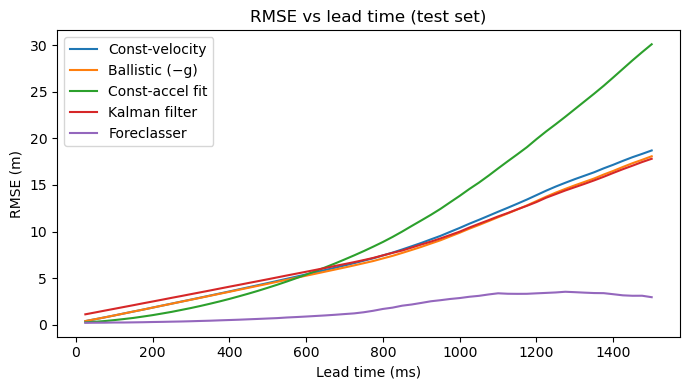

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


DT = 0.025
G = 9.81
ZONE_X = (12.0, 14.0)

M = X_observed_test.shape[1]   
K = X_forecast_test.shape[1]   
N = X_observed_test.shape[0]


def rmse(a, b, axis=None):
    return np.sqrt(np.mean((a - b) ** 2, axis=axis))

def zone_mask(x_true, zone=ZONE_X):
    return (x_true >= zone[0]) & (x_true <= zone[1])

def zone_rmse(pred, true, mask):
    return np.sqrt(np.mean((pred[mask] - true[mask]) ** 2))


v_est = (X_observed_test[:, -1] - X_observed_test[:, -2]) / DT        
t_grid = np.arange(1, K + 1) * DT                                     
naive_forecast = X_observed_test[:, -1:, :] + v_est[:, None, :] * t_grid[None,:,None]


x_pred_ball = X_observed_test[:, -1, 0][:, None] + v_est[:,0,None] * t_grid
y_pred_ball = X_observed_test[:, -1, 1][:, None] + v_est[:,1,None] * t_grid - 0.5*G*t_grid**2
ballistic_forecast = np.stack([x_pred_ball, y_pred_ball], axis=2)


t_obs = np.arange(M) * DT
t_full = np.arange(M, M+K) * DT
x_ca = []; y_ca = []
for i in range(N):
    cx = np.polyfit(t_obs, X_observed_test[i,:,0], 2)
    cy = np.polyfit(t_obs, X_observed_test[i,:,1], 2)
    x_ca.append(np.polyval(cx, t_full))
    y_ca.append(np.polyval(cy, t_full))
ca_forecast = np.stack([x_ca, y_ca], axis=2)          


# state s=[x,y,vx,vy];  z=[x,y]
A = np.array([[1,0,DT,0],
              [0,1,0,DT],
              [0,0,1,0 ],
              [0,0,0,1 ]], float)
u = np.array([0, -0.5*G*DT**2, 0, -G*DT])
Q = np.diag([1e-4,1e-4,1e-2,1e-2])
H = np.array([[1,0,0,0],
              [0,1,0,0]], float)
R = np.eye(2)*0.15**2

def kf_one(obs):
    vx0 = (obs[1,0]-obs[0,0]) / DT
    vy0 = (obs[1,1]-obs[0,1]) / DT
    s = np.array([obs[1,0], obs[1,1], vx0, vy0])
    P = np.eye(4)*1e-2
    for t in range(2, M):
        s = A @ s + u
        P = A @ P @ A.T + Q
        y = obs[t] - H @ s
        S = H @ P @ H.T + R
        Kk= P @ H.T @ np.linalg.inv(S)
        s = s + Kk @ y
        P = (np.eye(4)-Kk@H) @ P

    out = np.empty((K,2))
    for k in range(K):
        s = A @ s + u
        out[k] = s[:2]
    return out

kf_forecast = np.stack([kf_one(X_observed_test[i]) for i in range(N)], axis=0)


methods = {
    "Const-velocity":   naive_forecast,
    "Ballistic (−g)":   ballistic_forecast,
    "Const-accel fit":  ca_forecast,
    "Kalman filter":    kf_forecast,
    "Foreclasser":      mean_forecast
}

rows = []
mask_zone = zone_mask(X_forecast_test[...,0])
for name, pred in methods.items():
    rows.append({
        "method": name,
        "RMSE_all":   rmse(pred, X_forecast_test),
        "RMSE_zone":  zone_rmse(pred, X_forecast_test, mask_zone)
    })

df = pd.DataFrame(rows).set_index("method").sort_values("RMSE_all")
display(df.style.format("{:.3f}"))


ms = np.arange(1, K+1)*DT*1000
plt.figure(figsize=(7,4))
for name,pred in methods.items():
    plt.plot(ms, rmse(pred, X_forecast_test, axis=(0,2)), label=name)
plt.xlabel("Lead time (ms)"); plt.ylabel("RMSE (m)")
plt.title("RMSE vs lead time (test set)")
plt.legend(); plt.tight_layout(); plt.show()
